# Spooky author classification

The dataset is procured from a past [kaggle competition](https://www.kaggle.com/c/spooky-author-identification/data). The data contains textual excerpts from spooky stories and our task is to map textual excerpts to their respective (three) authors.

This notebook is broken down into the following sections:

1. Data loading
- Extracting meta features
- Exploratory data analysis (EDA)
- Splitting data into train and test
- Data pre-processing
- Feature engineering
- Evaluation metric
- Model fitting
- Result comparison and final model selection
- Sensitivity analysis of final model
- Learnings

# Importing libraries

We start by importing all libraries that would be used throughout this project.

In [1]:
# Importing required libraries

# General libraries
import os
from time import time

# Data processing libraries
import math
import re
import numpy as np
import pandas as pd
from scipy import sparse

# Visualization libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from keras.utils import np_utils

# Text processing libraries
import string
import collections
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Modelling libraries
from sklearn import model_selection, preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Embedding
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import SpatialDropout1D, Dropout
from keras.callbacks import History, ModelCheckpoint
import fasttext

Using TensorFlow backend.


We also download some *popular* nltk datasets that would be used for text processing later. This would be a one time download.

In [2]:
# Download NLTK datasets for the first time
try:
    print(nltk.pos_tag(nltk.word_tokenize('This is a test')))
except:
    nltk.download('popular')

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('test', 'NN')]


In [3]:
%matplotlib inline

# Enable seaborn style plotting
sns.set()

# 1. Data loading
In this section we explore our dataset by first loading the data and checking a sample of the data.

In [4]:
# Read in data and check a data sample
df = pd.read_csv('Dataset/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# Basic data counts
print("There are {} text rows in the dataset" .format(df.shape[0]))
print("There text are written by one of {} authors" .format(df['author'].nunique()))
print("There are no duplicate texts in the data") if df['text'].nunique()==len(df) else print("There are duplicate texts in the data")
print("There are {} null texts in the data" .format(df['text'].isnull().sum()))

There are 19579 text rows in the dataset
There text are written by one of 3 authors
There are no duplicate texts in the data
There are 0 null texts in the data


# 2. Extracting meta features
Here we would extract some text meta feature that could possibly help in author prediction. These meta features are more of a summary of the excerpts instead of using the text itself. Following are the meta features we would extract:
* Word Count
* Character Count
* Average word length
* Punctuation count
* Upper case word count
* Title case word count
* Frequency distribution of parts of speech tags:
 * Noun Count
 * Verb Count
 * Adjective Count
 * Adverb Count
 * Pronoun Count
 
**Note**: Although we could have done this in the `Feature engineering` section but we are doing it before in order to generate some visualizations on this data in the next section

In [6]:
# general word metadata
df['char_count'] =              df['text'].apply(len)
df['word_count'] =              df['text'].apply(lambda x: len(x.split()))
df['word_density'] =            df['char_count'] / (df['word_count'] + 1)
df['punctuation_count'] =       df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] =        df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] =   df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# parts of speech metadata
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' :  ['RB','RBR','RBS','WRB']
        }

tagger = nltk.tag.perceptron.PerceptronTagger()

# function to check and get the part of speech tag count of words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wordsList = nltk.word_tokenize(x)
        tagged = tagger.tag(wordsList) 
        for word in tagged:
            ppo = word[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


df['noun_count'] =  df['text'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] =  df['text'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count'] =   df['text'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count'] =   df['text'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] =  df['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [7]:
# getting fractional metrics for each excerpt
df['frac_punctuation_count'] =      df['punctuation_count']/df['char_count']
df['frac_title_word_count'] =       df['title_word_count']/df['word_count']
df['frac_upper_case_word_count'] =  df['upper_case_word_count']/df['word_count']

df['frac_noun_count'] =             df['noun_count']/df['word_count']
df['frac_verb_count'] =             df['verb_count']/df['word_count']
df['frac_adj_count'] =              df['adj_count']/df['word_count']
df['frac_adv_count'] =              df['adv_count']/df['word_count']
df['frac_pron_count'] =             df['pron_count']/df['word_count']

# 3. Exploratory Data Analysis (EDA)
Next we see data distribution across each author to see if any class imbalance exists and correct for that accordingly. We also draw some word clouds for each of the authors in order to get an overview of the writing styles of the authors. Finally, we check the distributions of each of the extracted meta features across authors to gain early insights on the utility of these features for model classification.
### 3.1 Author distribution
We first make functions for creating bar chart and pie chart for checking author distributions

In [8]:
# Define a function to draw frequency bar plot distribution for a categorical variables
def show_freq_dist(labels, counts):
    x = np.arange(len(labels))
    _ = plt.bar(x, counts)
    _ = plt.ylabel('Count', fontsize = 12)
    _ = plt.xticks(x, labels, fontsize = 12)
    plt.title('Frequency Distribution')
    plt.show()

# Define a function to draw a pie chart for a categorical function
def show_pie(labels, counts):
    _ = plt.pie(counts, labels = labels, autopct='%.1f%%', radius=1.5)
    plt.show()

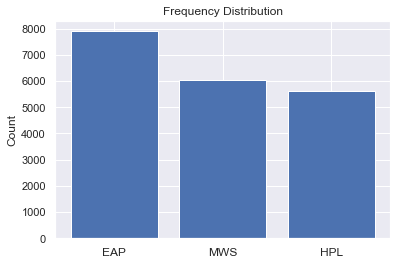

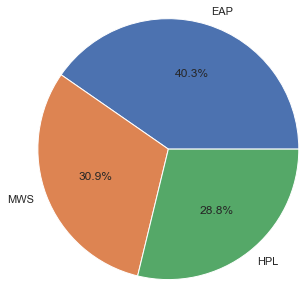

In [9]:
labels = df.author.value_counts().index
counts = df.author.value_counts()
#Generate frequency bar plot and pie chart for author distribution
show_freq_dist(labels, counts)
show_pie(labels, counts)

We can see from the plots above that the dataset doesn't suffer hugely from unbalanced class problem

### 3.2 Word clouds
Next we draw word clouds for each of the three authors in order to gain early insights into the choice of words and hence the writing styles of each of the authors

In [10]:
def generate_word_clouds(df, word_remove = None):
    # Create stopword list as a union of wordcloud and nltk stopwords
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    if word_remove == None:
        stopwords = set(nltk_stopwords) | STOPWORDS
    else:
        stopwords = set(nltk_stopwords) | STOPWORDS | set(word_remove)
    
    fig = plt.figure(figsize=(16,13))
    for name_counter, name in enumerate(list(set(df.author))):
        ax = fig.add_subplot(1, len(set(df.author)), name_counter+1)
        text = " ".join(sentence for sentence in df[df.author == name].text)
        wordcloud = WordCloud(max_words=1000, stopwords=stopwords, background_color="white", max_font_size= 60).generate(text)
        # Display the generated image
        _ = plt.imshow(wordcloud, interpolation='bilinear')
        _ = plt.title('Word cloud for {} ({} words) \n'.format(name, len(re.findall(r"\w[\w']+", text))))
        _ = plt.axis("off")
    plt.show()

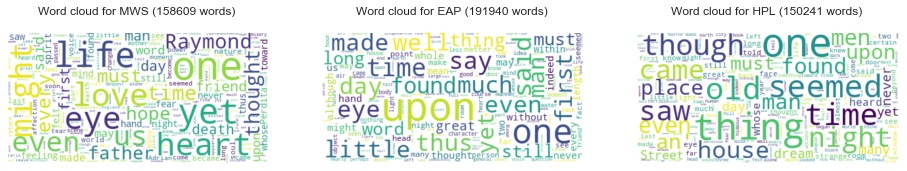

In [11]:
generate_word_clouds(df)

The above word cloud shows lots of usage of word `one` by all the three authors (more so by HPL and MWS). We remove this word just to see some more differentiation. Note though that the number of words mentioned in word cloud titles are rather all the words, however the word clouds remove the stop words and the words passed using `words_remove` argument and only show top 1000 words as mentioned in the `max_words` argument to `WordCloud` function.

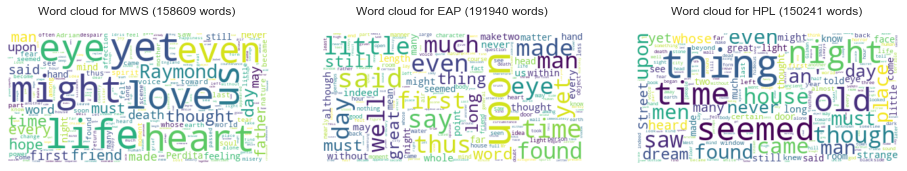

In [12]:
generate_word_clouds(df, word_remove = ['one'])

As can be seen above, there is considerable difference in the choice of words used by each of the authors. This could be due to the mixture of two reasons:
- Difference in writing style of the authors
- Difference in the story plot of the authors

All in all, it seems some combination of these words would be helpful in author prediction

### 3.3 Meta features plots
Next we check the difference in average of each meta-feature across the three authors. The general intuition is that meta-features with substantial difference across the authors would likely be good candidate variables for author prediction

In [13]:
def generate_box_plots(df, col_list, yscale_lim_percentile=None):
    fig_cols = 3
    fig_rows = math.ceil(len(col_list)/fig_cols)
    fig = plt.figure(figsize=(16,fig_rows*5)) #setting figure width = fig_rows*5
    for col_counter, col_name in enumerate(col_list):
        ax = fig.add_subplot(fig_rows, fig_cols, col_counter+1)
        _ = sns.boxplot(x = 'author', y = col_name, data=df)
        ax.set_title(col_name,fontsize=15)
        ax.set_xlabel('')
        ax.set_ylabel(col_name)
        ax.set_ylim(bottom=0.98*np.percentile(df[col_name], 0)) #set bottom ylim to slightly less than min value
        if yscale_lim_percentile is not None:
            ax.set_ylim(top=np.percentile(df[col_name], yscale_lim_percentile))
    plt.show()

Next we generate box plots for all absolute scale meta features using the function above. We also limit the y-axis to 99<sup>th</sup> percentile for a zoomed-in view of the interquartile range

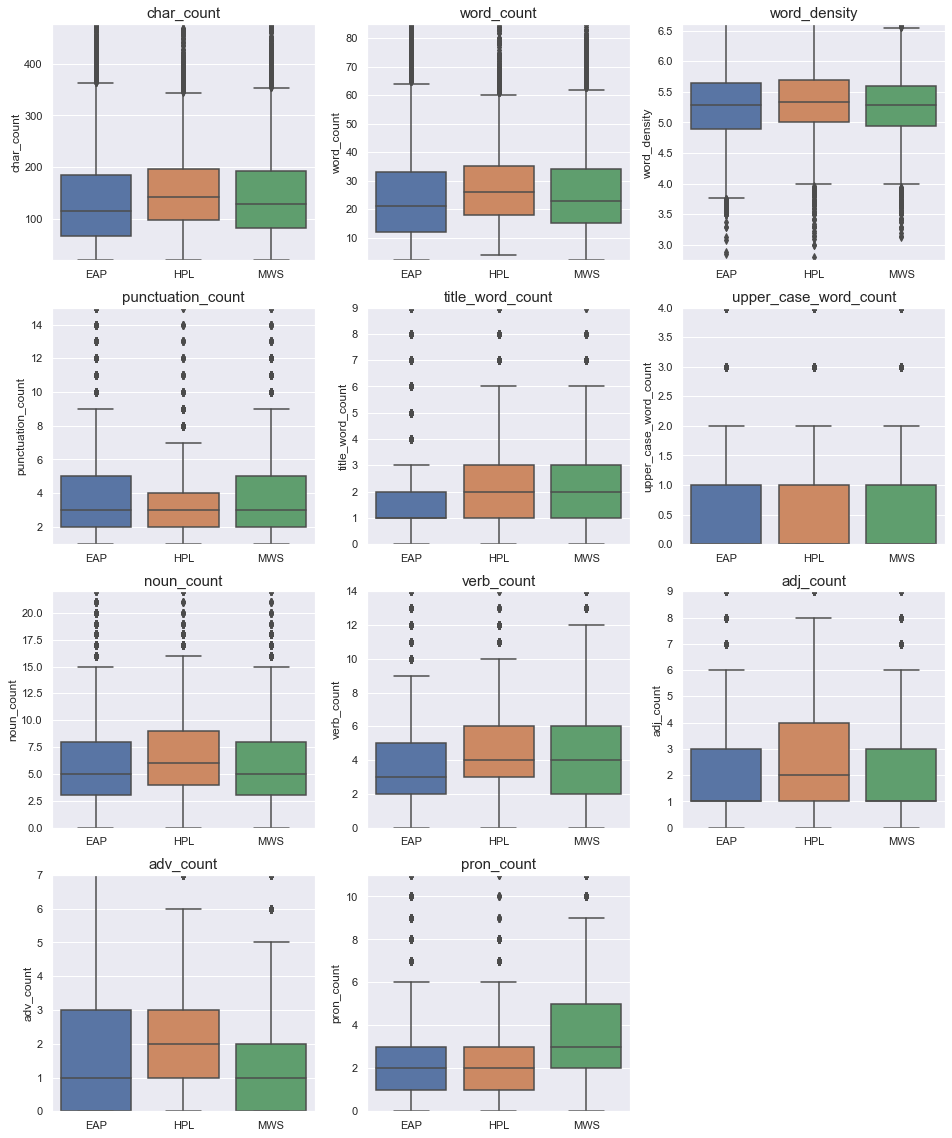

In [14]:
# box plot of absolute meta features
generate_box_plots(df, ['char_count', 'word_count', 'word_density',
                       'punctuation_count', 'title_word_count', 'upper_case_word_count',
                       'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count'], 
                   yscale_lim_percentile=99)

From the above plots, `adv_count` and `pron_count` seem to be most differentiated across authors while other variables also exhibit seeming differentiation.

Next we generate box plots for all fractional scale meta features using the function above. We again limit the y-axis to 99<sup>th</sup> percentile for a zoomed-in view of the interquartile range

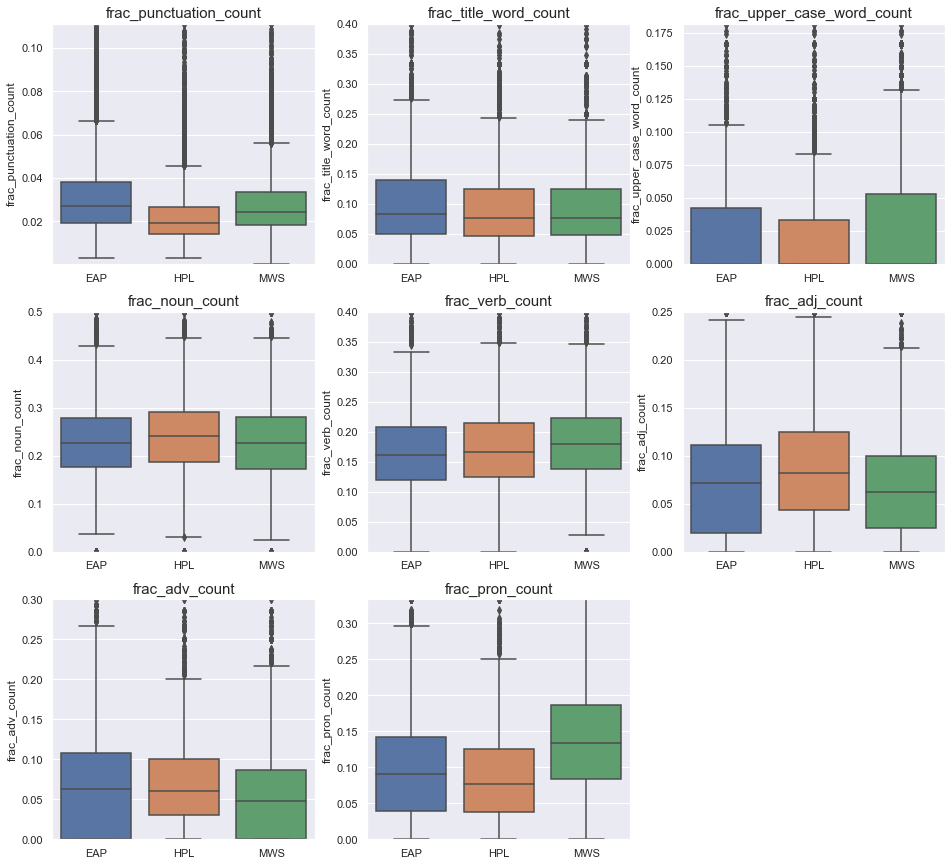

In [15]:
# box plot of fractional meta features
generate_box_plots(df, ['frac_punctuation_count', 'frac_title_word_count',
                       'frac_upper_case_word_count', 'frac_noun_count', 'frac_verb_count',
                       'frac_adj_count', 'frac_adv_count', 'frac_pron_count'], 
                   yscale_lim_percentile=99)

From the above plots, `frac_punctuation_count`, `frac_adj_count` and `frac_pron_count` seem to be most differentiated across authors

# 4. Splitting data into train and test
We now split our data into train and test.

In [16]:
# Carve out 10% testing set
X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop(['id', 'author'], axis = 1), 
                                                                    df['author'], 
                                                                    test_size = 0.1, 
                                                                    random_state = 42)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Show the results of split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 17621 samples.
Testing set has 1958 samples.


In [17]:
# printing the mapping performed by label encoder
print(list(zip(np.unique(y_train), encoder.inverse_transform(np.unique(y_train)))))

[(0, 'EAP'), (1, 'HPL'), (2, 'MWS')]


# 5. Data pre-processing
We now prepare functions to apply some pre-processing to textual excerpts. They would include:
* Lowering case
* Removing punctuation
* Removing stopwords
* Lemmatization

Note that we are not concerned with ***spell corrections*** as these are excerpts taken from novels and hence spellings should not be an issue. Also we would not do any ***sentence tokenization*** as most excerpts are single sentences

In [18]:
# helper function that generates lemmatized sentence- would be used in main function preprocess_text
def lemmatize_sentence(sent, tag_dict, tagger, lemmatizer, rm_stopwords, nltk_stopwords):
    sent = nltk.word_tokenize(sent)
    tag = tagger.tag(sent)
    tag = [tag_dict.get(t[1][0].upper(), nltk.corpus.wordnet.NOUN) for t in tag]
    if rm_stopwords==True:
        sent = " ".join([lemmatizer.lemmatize(wrd, t) if wrd.lower() not in nltk_stopwords else wrd
                         for (wrd, t) in zip(sent,tag)])
    else:
        sent = " ".join([lemmatizer.lemmatize(wrd, t)
                         for (wrd, t) in zip(sent,tag)])
    return sent


# main function for text preprocessing
def preprocess_text(X, rm_punc=True, rm_lemma=True, rm_lowercase=True, rm_stopwords=True):
    '''
    inputs:
        X: pd.Series type object containing text strings
        rm_punc: whether punctuation needs to be removed (True/False)
        rm_lemma: whether text needs to lemmatized (True/False)
        rm_lowercase: whether lower case needs to be done (True/False)
        rm_stopwords: whether stopwords need to be removed (True/False)
    '''
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    # remove punctuation
    if rm_punc==True:
        X = X.apply(lambda x: "".join(_ for _ in x if _ not in string.punctuation))
    # lemmatization
    if rm_lemma==True:
        tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                    "N": nltk.corpus.wordnet.NOUN,
                    "V": nltk.corpus.wordnet.VERB,
                    "R": nltk.corpus.wordnet.ADV}
        tagger = nltk.tag.perceptron.PerceptronTagger()
        lemmatizer = nltk.stem.WordNetLemmatizer()
        X = X.apply(lemmatize_sentence, args=(tag_dict, tagger, lemmatizer, rm_stopwords, nltk_stopwords))
    # lowercase
    if rm_lowercase==True:
        X = X.str.lower()
    # remove stopwords
    if rm_stopwords==True:
        X = X.apply(lambda x: " ".join([wrd for wrd in nltk.word_tokenize(x) if wrd.lower() not in nltk_stopwords]))
    return X

# 6. Feature engineering
Next up, we will do some feature engineering on the text excerpts to be able to lend them as inputs to various ML models. We would try out the following methods:
- **Meta text features** (already extracted earlier): These include text meta features like word counts, character counts, punctuation counts, etc.
- **Count vectorizer for ML models**: This is a matrix notation of the corpus where each row is a sentence/document and each column is a term (word/character) in that document. The matrix values are counts/frequencies of a specific term in a specific document
- **TF-IDF vectorizer for ML models**: This also is a matrix notation of documents (rows) and terms (column) however the matrix values are a bit more sophisticated in that they provide the relative importance of the term with respect to the entire document
- **Keras tokenizer features for neural net models**: This is an alternative to sklearn's bag of words vectorizers above. They generally work better with neural net models
- **Pre-trained word embeddings for neural net models**: Word embeddings are a way of representing words (or documents) using a dense vector representation (as opposed to sparse representations provided by count/TF-IDF vectorizers). Often, they are initialized with pre-trained embeddings especially if the train corpus is small. They are generally preferred for training neural nets models

We first make a function for fitting Count vectorizer and TF-IDF vectorizer on text data. This would be used to make features for the ML models later

In [19]:
def count_tfidf_vectorizer(train_data, test_data, mode, analyzer='word', ngram_range=(1,1), max_features=None):
    '''
    inputs:
       - train_data: train text data column
       - test_data: test text data column
       - mode: can be either of count or tfidf for generating respective features
       - analyzer: the 'analyzer' argument to the sklearn vectorizer function. Can be 'word', 'char', etc.
       - ngram_range: the range of n_grams features to build (lower and upper bounds inclusive)
                       For e.g. ngram_range=(1,3) would build uni-grams, bi-grams and tri-grams
       - max_features: cut-off for max features to consider. Filtering of features would be done based on frequency
    '''
    if mode=='count':
        vec = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, max_features=max_features, token_pattern=r'\w{1,}')
    elif mode=='tfidf':
        vec = TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range, max_features=max_features, token_pattern=r'\w{1,}')
    else:
        raise ValueError('mode argument should be count or tfidf')
    vec.fit(train_data)
    train_data = vec.transform(train_data)
    test_data = vec.transform(test_data)
    return train_data, test_data

We also make a function for initializing keras tokenizer API and fitting it on train data. The function returns integer encoded train and test sequences of similar lengths. These features would be used for `Neural Net` section later

In [20]:
# declaring and fitting keras tokenizer object on train data
def tokenize_encode_documents(train, test, max_length_percentile):
    '''
    inputs:
       - train: train text sequences
       - test: test text sequences
       - max_length_percentile: percentile word count threshold (0 to 100) for text sequences.
                               Text sequences with length above this threshold would be truncated.
                               Text sequences with length below this threshold would be padded with 0s.
    '''
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train)
    word_counts = train.apply(lambda x: len(x.split()))
    max_length = int(np.percentile(word_counts, max_length_percentile))
    # encoding words into fixed-length sequences in train data
    train_enc = tokenizer.texts_to_sequences(train)
    train_enc = pad_sequences(train_enc, maxlen=max_length, padding='post', truncating='post')
    # encoding words into fixed-length sequences in test data
    test_enc = tokenizer.texts_to_sequences(test)
    test_enc = pad_sequences(test_enc, maxlen=max_length, padding='post', truncating='post')
    print('Generated sequences with similar lengths of {}'.format(max_length))
    return tokenizer.word_index, train_enc, test_enc

We also make a function for reading pre-trained word embeddings in non-binary text format. This function would be used in the `Neural Net` section later

In [21]:
# helper function for loading pre-trained embedding file to dictionary
def load_embedding_in_dict(filepath, encoding):
    embeddings_index = {}
    f = open(filepath, encoding=encoding)
    for line in f:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
    f.close()
    return embeddings_index

# function to map each word in tokenizer object to its pre-trained embedding
def map_word_to_embeddings(filepath, encoding, word_index):
    '''
    inputs:
       - filepath: filepath of the pre-trained embedding file
       - encoding: encoding of the pre-trained embedding file (e.g. 'utf8')
       - word_index: keras tokenizer word_index dictionary attribute based on train data
    '''    
    embeddings_index = load_embedding_in_dict(filepath, encoding) # load file
    embedding_dim = len(embeddings_index['the']) # taking size of a sample word as all word vectors are equally sized
    vocab_size = len(word_index)+1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, embedding_dim

# 7. Evaluation metric
For evaluating model performance, we would be using multi-class `log loss` (or cross entropy) metric. Although, we could have used `accuracy` as an evaluation metric as well (as our target classes are balanced) but we chose `log loss` in order to be consistent with the kaggle challenge.

Cross entropy (or log-loss) is based on the concept of maximum likelihood of predictions i.e. a model which predicts higher probabilities for the actual observed events is better than models that don’t quite do so. Mathematically, cross entropy (or log loss) is given by the expression:

$$-\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{M} y_{ij}\log(p_{ij})$$

where,
* N = number of observations (text excerpts in this case)
* M = number of classes (3 in this case)
* $y_{ij}$ = 1 if observation i belongs to class j else 0
* $p_{ij}$ = predicted probability that observation i belongs to class j

Our objective is to make `log loss` as low as possible (ideally close to 0).

We would be using inbuilt `log loss` metric in sklearn for our purposes. This can be found under `sklearn.metrics.log_loss`. We would also track `accuracy` as a helper evaluation metric. This can be found under `sklearn.metrics.accuracy_score`

# 8. Model fitting
We now turn to model fitting on the extracted features. We would divide this section into following model classes:
- Benchmark model
- ML based model based on:
 - Meta features
 - Text based features
- Ensemble of ML models using *stacking*
- Neural net based models
- Other classification frameworks e.g. FastText by Facebook

We start by creating a function `train_predict` that fits a given model on the data for different sample sizes and then evaluates model performance. We also create a confusion matrix plotting function `show_confusion_matrix`

In [22]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, scenario=None): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time()
    learner = learner
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    predictions_proba_test = learner.predict_proba(X_test)
    predictions_proba_train = learner.predict_proba(X_train[:300])
    end = time()
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = metrics.accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = metrics.accuracy_score(y_test, predictions_test)
    
    # Compute log loss on the the first 300 training samples
    results['ll_train'] = metrics.log_loss(y_train[:300], predictions_proba_train)
        
    # Compute log loss on the test set
    results['ll_test'] = metrics.log_loss(y_test, predictions_proba_test)
       
    # Success
    if scenario==None:
        print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    else:
        print("{} trained on {} samples for scenario {}.".format(learner.__class__.__name__, sample_size, scenario))
        
    # Return the results
    return results


# function to plot confusion matrix. Code reference from https://seaborn.pydata.org/generated/seaborn.heatmap.html
def show_confusion_matrix(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    categories = list(encoder.inverse_transform([0,1,2]))
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', square=True, linewidths=.5)
    ax.set_ylabel('Actual', labelpad=20, fontsize=25)
    ax.set_xlabel('Predicted', labelpad=20, fontsize=25)
    _ = plt.xticks([0.5,1.5,2.5], categories, fontsize=15)
    _ = plt.yticks([0.5,1.5,2.5], categories, fontsize=15)
    plt.show()

## 8.1 Benchmark model
Our benchmark model is a **logistic classifier** trained on single-gram bag of words. We try the model with and without text preprocessing (stopwords removal, punctuation removal, lemmatization, etc.) to see the effect on test `log loss` and `accuracy`. We would try different combinations of punctuation removal, stopwords and lemmatization schemas below.

In [23]:
benchmark_results = {}

# fix parameters for benchmark model
clf_benchmark = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42)
sample_size = len(y_train)

for f_stopword in [True, False]:
    for f_lemma in [True, False]:
        for f_punc in [True, False]:
            scenario = 'sw_' + str(f_stopword)[0] + '_lm_' + str(f_lemma)[0] + '_pn_' + str(f_punc)[0]
            
            X_train_benchmark = preprocess_text(X_train.text, rm_punc=f_punc, rm_lemma=f_lemma, rm_stopwords=f_stopword)
            X_test_benchmark = preprocess_text(X_test.text, rm_punc=f_punc, rm_lemma=f_lemma, rm_stopwords=f_stopword)
            
            X_train_benchmark, X_test_benchmark = count_tfidf_vectorizer(X_train_benchmark, X_test_benchmark, mode='count')
            benchmark_results[scenario] = train_predict(clf_benchmark, sample_size, X_train_benchmark, y_train,
                                                                                    X_test_benchmark, y_test, scenario)


LogisticRegression trained on 17621 samples for scenario sw_T_lm_T_pn_T.
LogisticRegression trained on 17621 samples for scenario sw_T_lm_T_pn_F.
LogisticRegression trained on 17621 samples for scenario sw_T_lm_F_pn_T.
LogisticRegression trained on 17621 samples for scenario sw_T_lm_F_pn_F.
LogisticRegression trained on 17621 samples for scenario sw_F_lm_T_pn_T.
LogisticRegression trained on 17621 samples for scenario sw_F_lm_T_pn_F.
LogisticRegression trained on 17621 samples for scenario sw_F_lm_F_pn_T.
LogisticRegression trained on 17621 samples for scenario sw_F_lm_F_pn_F.


We now compare the performance of logistic classifier with different text preprocessing schemas.

For reference, an example nomenclature of a schema is as follows:

***sw_T_lm_F_pn_F***: model performance with stopwords removed (T), without lemmatization (F) and without punctuation removal (F)


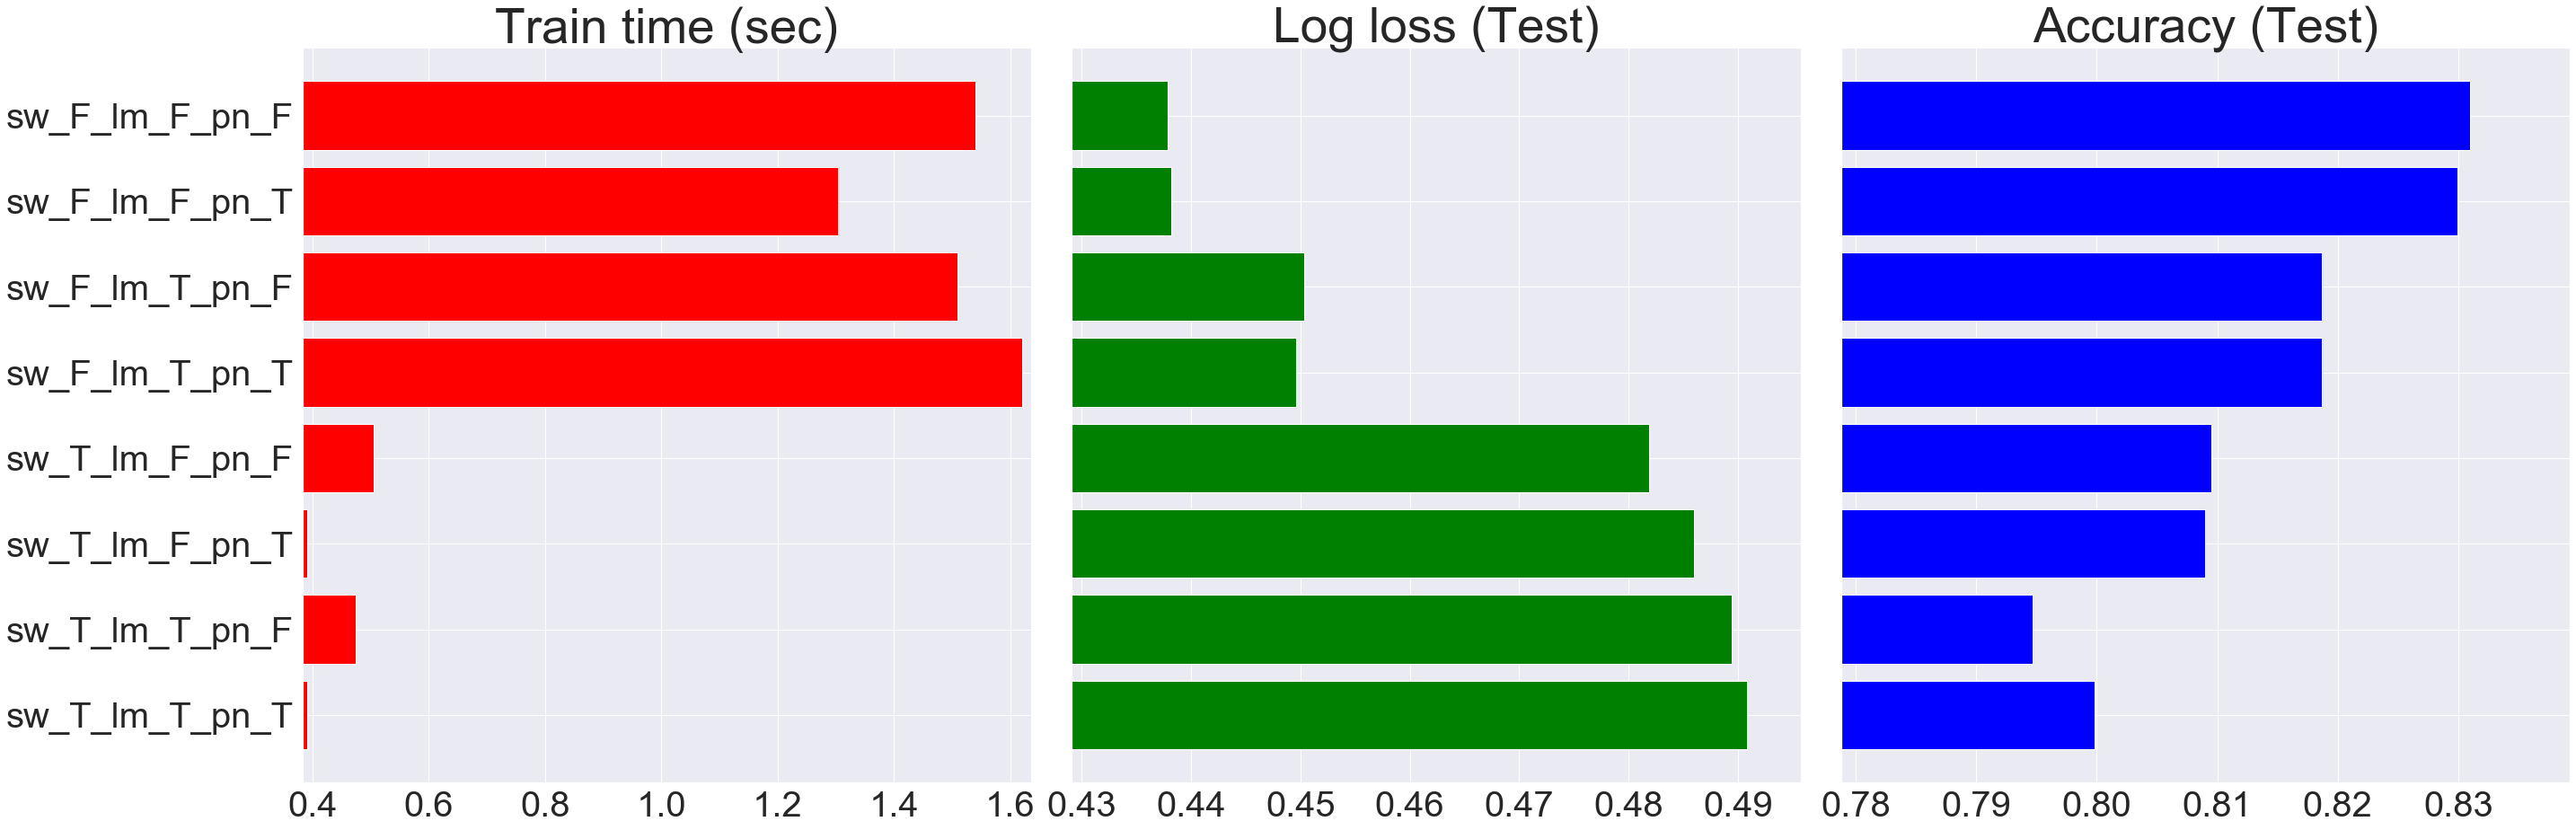

In [24]:
# comparing performance of single-gram logistic classifier (benchmark model) with different text pre-processing schemas
metrics_bench = ['train_time', 'll_test', 'acc_test']
metric_labels = ['Train time (sec)', 'Log loss (Test)', 'Accuracy (Test)']
colors_bench = ['red', 'green', 'blue']
label = benchmark_results.keys()

fig = plt.figure(figsize=(40,13))
for metric_counter, metric in enumerate(metrics_bench):
    ax = fig.add_subplot(1, len(metrics_bench), metric_counter+1)
    metric_data = [benchmark_results[scenario][metric] for scenario in label]
    y = np.arange(len(label))
    _ = plt.barh(y, metric_data, color=colors_bench[metric_counter])
    _ = plt.title(metric_labels[metric_counter], fontsize=55)
    _ = plt.xticks(fontsize=40)
    _ = plt.xlim(left = 0.98*min(metric_data), right = 1.01*max(metric_data))
    if metric_counter==0:
        _ = plt.yticks(y, label, fontsize=40)
    else:
        _ = plt.yticks(y, '', fontsize=40)
    _ = plt.tight_layout()
plt.show()

del metrics_bench, metric_labels, colors_bench, label

From the results above, we can see that **preprocessing text is rather leading to worse results** i.e. higher log loss and lower accuracy. Especially removing stopwords seem to be significantly reducing the model performance followed by lemmatization.

One possible explanation is:
- Stopwords usage is significantly different among authors and we are able to infer important writing patterns by including those
- Choice of verb form also is an important parameter in author prediction which is lost if we do lemmatization

**Final benchmark model**: Accordingly, we can chose the logistic single-gram feature based model with no text preprocessing as our benchmark model. This model has the following schema and performance:

In [25]:
benchmark_ll_scores = [benchmark_results[scenario]['ll_test'] for scenario in benchmark_results.keys()]
benchmark_acc_scores = [benchmark_results[scenario]['acc_test'] for scenario in benchmark_results.keys()]
best_benchmark_counter = np.argmin(benchmark_ll_scores)

benchmark_ll = benchmark_ll_scores[best_benchmark_counter]
benchmark_acc = benchmark_acc_scores[best_benchmark_counter]

print("The benchmark model has schema {} with test log loss of {} and accuracy of {}"
      .format(list(benchmark_results.keys())[best_benchmark_counter],
              round(benchmark_ll,3),
              round(benchmark_acc,3)))


The benchmark model has schema sw_F_lm_F_pn_F with test log loss of 0.438 and accuracy of 0.831


We can also observe the confusion matrix of the baseline model predictions using the text pre-processing setting above. Here we observe a lot many excerpts belonging to HPL/MWS are wrongly getting predicted as those by EAP

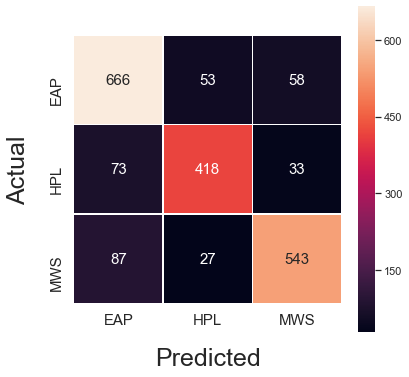

In [26]:
X_train_benchmark = preprocess_text(X_train.text, rm_punc=False, rm_lemma=False, rm_stopwords=False)
X_test_benchmark = preprocess_text(X_test.text, rm_punc=False, rm_lemma=False, rm_stopwords=False)

X_train_benchmark, X_test_benchmark = count_tfidf_vectorizer(X_train_benchmark, X_test_benchmark, mode='count')

best_clf_benchmark = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42)
best_clf_benchmark.fit(X_train_benchmark, y_train)
best_benchmark_y_pred = best_clf_benchmark.predict(X_test_benchmark)

show_confusion_matrix(y_test, best_benchmark_y_pred)

## 8.2 ML models
We would divide this section into following:
- ML models on meta features
- ML models on count based features
- ML models on TF-IDF features
- Hyperparameter tuning on best model

We will fit **three models** on each of the above features (meta, count, TF-IDF). These three models would be:
- **Multinomial Naive-bayes**: One of its main advantages is that you can get really good results when data available is not much (~ a couple of thousand tagged samples) and computational resources are scarce. It also is one of the most used models for text classification
- **Support Vector Machine (SVM)**: Like Naive Bayes, SVM doesn’t need much training data to start providing accurate results. Although it needs more computational resources than Naive Bayes, SVM can achieve more accurate results
- **XGBoost**: XGBoost is an implementation of gradient boosted decision trees designed for speed and performance

**Note**: We would not be doing any text preprocessing before forming the features as that seems to worsen model performance (as observed from benchmark model evaluation).

We first make a function `evaluate_models` that provides a visual comparison of various model performances. Then we create a function `train_and_compare_ML_models` that takes in features of our choice, fits the three models and provides a visual comparison of their performance

In [27]:
# this function would be used in train_and_compare_ML_models
def evaluate_models(results, accuracy, ll):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the benchmark predictor
      - ll: The score for the benchmark predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (17,12))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'll_train', 'pred_time', 'acc_test', 'll_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("Log Loss")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("Log Loss")
    
    # Add titles
    ax[0, 0].set_title("Model Training", fontsize=16)
    ax[0, 1].set_title("Accuracy Score on Training Subset", fontsize=16)
    ax[0, 2].set_title("Log Loss on Training Subset", fontsize=16)
    ax[1, 0].set_title("Model Predicting", fontsize=16)
    ax[1, 1].set_title("Accuracy Score on Testing Set", fontsize=16)
    ax[1, 2].set_title("Log Loss on Testing Set", fontsize=16)
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = ll, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = ll, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1.5))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1.5))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 25, y = 1.04)
    plt.show()



def train_and_compare_ML_models(X_train, y_train, X_test, y_test, mode=''):
    """
    Train and visualize performance of three learners.
    
    inputs:
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
       - mode: brief description of feature schema
    """
    # Initialize the three models
    clf_A = SVC(probability=True, gamma='scale', random_state=42)
    clf_B = MultinomialNB()
    clf_C = xgb.XGBClassifier(random_state=42)

    # Calculating the number of samples for 1%, 10%, and 100% of the training data
    samples_100 = len(y_train)
    samples_10 = int(0.1*samples_100)
    samples_1 = int(0.01*samples_100)

    # Collect results on the learners
    results = {}
    for clf in [clf_A, clf_B, clf_C]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_10, samples_100]):
            results[clf_name][i] = \
                            train_predict(clf, samples, X_train, y_train, X_test, y_test)

    ll_scores = [results[clf][2]['ll_test'] for clf in results.keys()]
    acc_scores = [results[clf][2]['acc_test'] for clf in results.keys()]
    best_counter = np.argmin(ll_scores)

    ll = ll_scores[best_counter]
    acc = acc_scores[best_counter]

    print("\nThe best ML model based on {} is {} with test log loss of {} and accuracy of {}"
          .format(mode,
                  list(results.keys())[best_counter],
                  round(ll,3),
                  round(acc,3)))
    
    # Run metrics visualization for the three supervised learning models chosen
    evaluate_models(results, benchmark_acc, benchmark_ll)

### 8.2.1 ML models on meta features
We first fit the models on text meta features (e.g. punctuation count, noun count, etc.)

SVC trained on 176 samples.
SVC trained on 1762 samples.
SVC trained on 17621 samples.
MultinomialNB trained on 176 samples.
MultinomialNB trained on 1762 samples.
MultinomialNB trained on 17621 samples.
XGBClassifier trained on 176 samples.
XGBClassifier trained on 1762 samples.
XGBClassifier trained on 17621 samples.

The best ML model based on text meta-features is XGBClassifier with test log loss of 0.941 and accuracy of 0.547


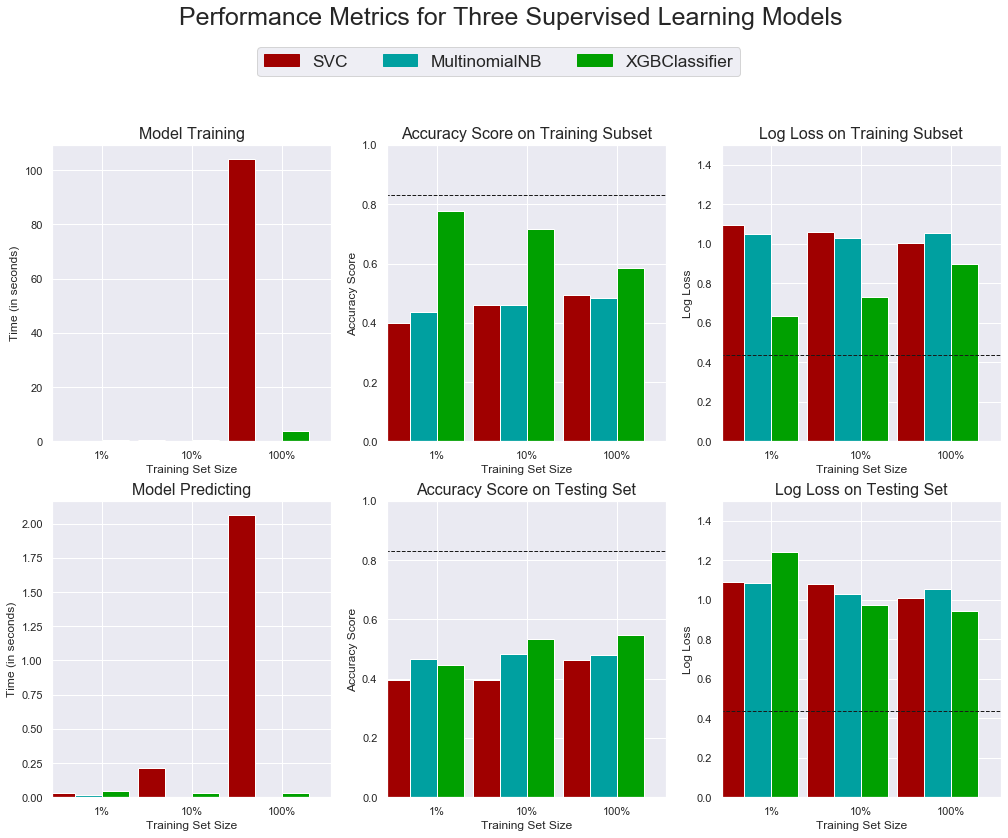

In [28]:
# train and test features
X_train_ML_meta = X_train.drop('text', axis = 1)
X_test_ML_meta = X_test.drop('text', axis = 1)

train_and_compare_ML_models(X_train_ML_meta, y_train, X_test_ML_meta, y_test, mode='text meta-features')

Here we see that that none of the models perform well enough on the meta features. Infact, their performance is significantly lower than the benchmark model (dashed lines in the log loss and accuracy plots- note that log loss needs to be reduced). The best model accuracy is <0.55 with the XGBoost classifier which gives a not so impressive log loss of ~0.94. We also observe that SVC classifier takes significantly longer time to train than others

### 8.2.2 ML models on count based features
We now fit the models on count based text features

SVC trained on 176 samples.
SVC trained on 1762 samples.
SVC trained on 17621 samples.
MultinomialNB trained on 176 samples.
MultinomialNB trained on 1762 samples.
MultinomialNB trained on 17621 samples.
XGBClassifier trained on 176 samples.
XGBClassifier trained on 1762 samples.
XGBClassifier trained on 17621 samples.

The best ML model based on count based text features is MultinomialNB with test log loss of 0.465 and accuracy of 0.835


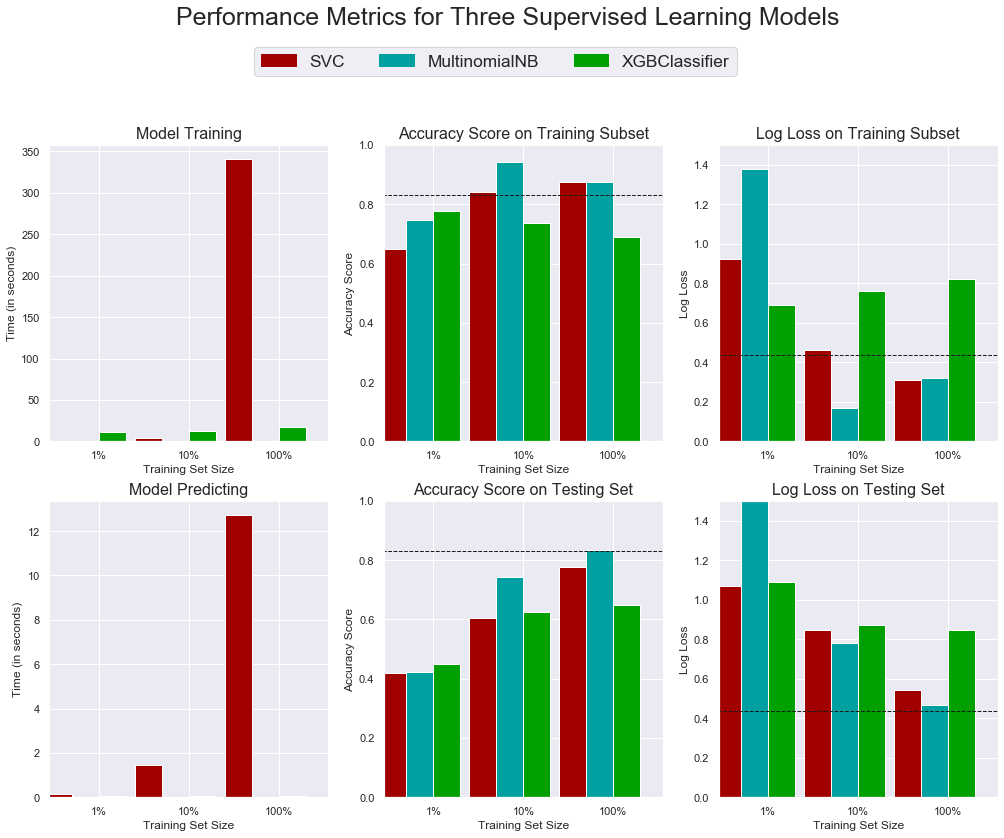

In [29]:
# train and test features
X_train_ML_count = X_train.text
X_test_ML_count = X_test.text

X_train_ML_count, X_test_ML_count = count_tfidf_vectorizer(X_train_ML_count, X_test_ML_count, mode='count')

train_and_compare_ML_models(X_train_ML_count, y_train, X_test_ML_count, y_test, mode='count based text features')

Here we see that the models start performing better with count based features. In fact, the performance of Multinomial Naive Bayes classifier is comparable to the benchmark model with a log loss marginally below par (~ 0.465) than benchmark model and accuracy infact slightly higher than benchmark model (~ 0.835). Again, we observe that SVC classifier takes significantly longer time to train than others.

### 8.2.3 ML models on TF-IDF features
We now fit the models on TF-IDF text features

SVC trained on 176 samples.
SVC trained on 1762 samples.
SVC trained on 17621 samples.
MultinomialNB trained on 176 samples.
MultinomialNB trained on 1762 samples.
MultinomialNB trained on 17621 samples.
XGBClassifier trained on 176 samples.
XGBClassifier trained on 1762 samples.
XGBClassifier trained on 17621 samples.

The best ML model based on tfidf text features is SVC with test log loss of 0.44 and accuracy of 0.821


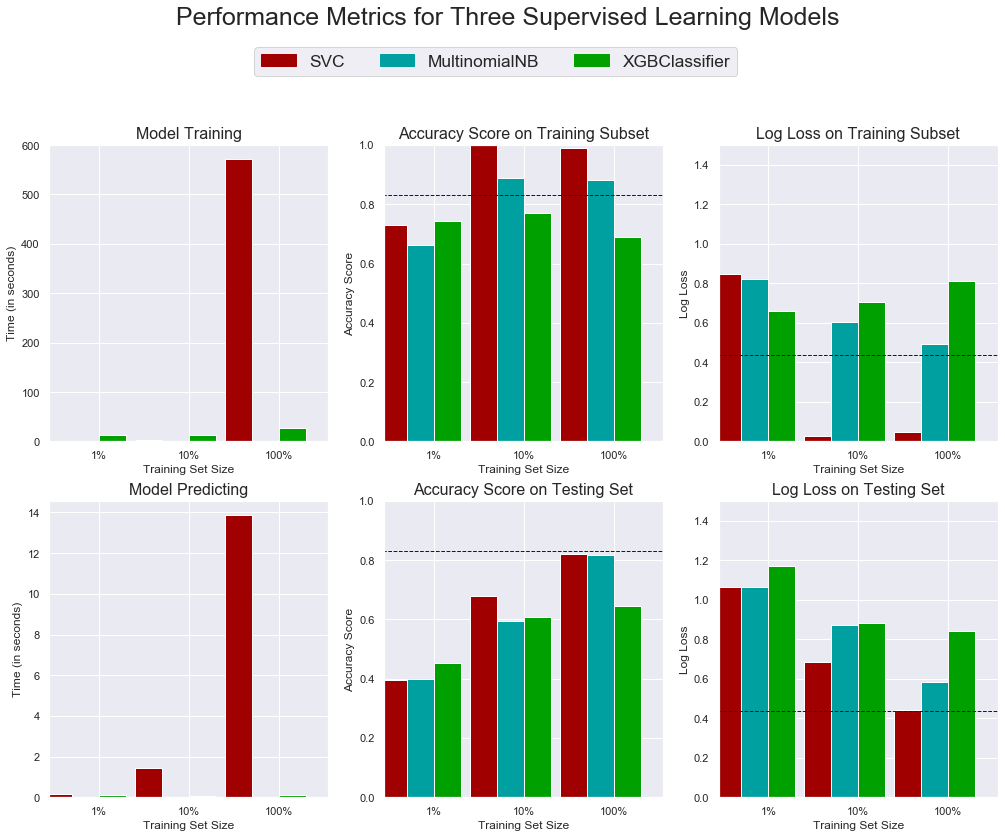

In [30]:
# train and test features
X_train_ML_tfidf = X_train.text
X_test_ML_tfidf = X_test.text

X_train_ML_tfidf, X_test_ML_tfidf = count_tfidf_vectorizer(X_train_ML_tfidf, X_test_ML_tfidf, mode='tfidf')

train_and_compare_ML_models(X_train_ML_tfidf, y_train, X_test_ML_tfidf, y_test, mode='tfidf text features')

Models based on TF-IDF features perform even better with the SVC classifier being the star performer. It achieves a log loss almost similar to the benchmark model (~ 0.44) and and accuracy slightly lower than benchmark model (~ 0.82) although again we observe that SVC classifier takes significantly longer time to train than others.

**Note**: We also tried running the model with n-gram count/TFIDF features but the model performance becomes worse. Specifically, the model starts to overfit may be because n-grams provide features that are very specific and might not be really observed in the corpus elsewhere. We are not listing the n-gram feature based results for the sake of brevity

### 8.2.4 Hyperparameter tuning
Next up we would be conducting hyperparameter tuning on the best performing model thus far. The best performance was exhibited by the SVC model based on TF-IDF features and hence we would tune that

**Note**: This step can take **significant** time to run depending on the number of machine cores. Skip running this cell if time is limited - as this is an independent module, the rest of the workbook would remain unaffected even if this cell is not run

In [31]:
# Declare base estimator
start_time = time()
clf = SVC(probability=True, gamma='scale', random_state=42)

# Declare parameter permutations to try
parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

# Declaring grid object
grid_obj = model_selection.GridSearchCV(clf, parameters, scoring='neg_log_loss', cv=3, n_jobs = -1)

grid_fit = grid_obj.fit(X_train_ML_tfidf, y_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions =       (clf.fit(X_train_ML_tfidf, y_train)).predict(X_test_ML_tfidf)
predictions_proba = (clf.fit(X_train_ML_tfidf, y_train)).predict_proba(X_test_ML_tfidf)
best_predictions =       best_clf.predict(X_test_ML_tfidf)
best_predictions_proba = best_clf.predict_proba(X_test_ML_tfidf)

end_time = time()

# Report the before-and-afterscores
print("Time taken: {} minutes\n".format(round((end_time-start_time)/60,1)))
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(metrics.accuracy_score(y_test, predictions)))
print("Log loss on testing data: {:.4f}".format(metrics.log_loss(y_test, predictions_proba)))
print("\nOptimized Model\n------")
print("Final accuracy score on testing data: {:.4f}".format(metrics.accuracy_score(y_test, best_predictions)))
print("Final log loss on testing data: {:.4f}".format(metrics.log_loss(y_test, best_predictions_proba)))
print("Final model has parameters {}".format(best_clf.get_params()))

Time taken: 58.6 minutes

Unoptimized model
------
Accuracy score on testing data: 0.8212
Log loss on testing data: 0.4402

Optimized Model
------
Final accuracy score on testing data: 0.8381
Final log loss on testing data: 0.4170
Final model has parameters {'C': 10, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


So we have achieved a bump up in log loss performance with hyperparameter tuning!!! The log loss of the optimized model is ~0.417 which is significantly lesser than the benchmark log loss of ~0.438. The accuracy as well jumps slightly from ~0.831 in the benchmark model to ~0.838 in the optimized model. We can also plot the confusion matrix of this tuned classifier below where we can observe that a lot many MWS and HPL predictions are getting falsely loaded into EAP

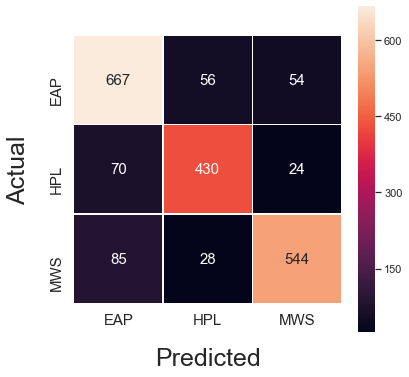

In [32]:
# plotting confusion matrix of the tuned SVC model
show_confusion_matrix(y_test, best_predictions)

## 8.3 Stacking ensemble of ML models
Ensembling is a powerful technique to combine several models to produce an even better model. In this project, we would develop a stacking ensemble wherein a combiner algorithm is trained to make a final prediction using the predictions of other algorithms as additional inputs ([reference](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking)). We would be making use of `mlxtend` package and specifically the `StackingCVClassifier` function for building the stacking ensemble classifier. This function uses cross-validation to prepare input for the combiner algorithm and hence prevents overfitting ([reference](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/)).

We would try out two different types of ensembles:
- **Stacking of multiple base learners on same features**: Here we use 3 different base learners (viz. SVC, XGBoost and Naive Bayes) and then combine their predictions (i.e. probabilities) using a combiner algorithm (viz. Logistic regression). All through we would be using the `tfidf` features as they showed best performance thus far (with SVC model)
- **Stacking of same base learner trained on multiple features**: Here we would be fitting the faster (yet performant) Naive Bayes algorithm on multiple features (viz. count, tfidf and character counts) and XGBoost on meta features. Finally, we would use these predicted probabilities as base learners and use XGBoost classifier to combine these base learners' predictions

### 8.3.1 Stacking of multiple base learners on same features
Here we use SVC, Naive Bayes and XGBoost as base models and then use logistic regression as the combiner model. We fit the base models on TF-IDF word features as they gave us the best scores earlier

In [33]:
start_sclf = time()

# initializing all base classifiers/learners
clf1 = SVC(probability=True, gamma='scale', random_state=42)
clf2 = MultinomialNB()
clf3 = xgb.XGBClassifier(random_state=42)
lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42)

# declaring the stacking ensemble model
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr,
                            random_state=42)

sclf.fit(X_train_ML_tfidf, y_train)
sclf_predictions = sclf.predict(X_test_ML_tfidf)
sclf_predictions_proba = sclf.predict_proba(X_test_ML_tfidf)

end_sclf = time()

print("Time taken: {} seconds".format(round(end_sclf-start_sclf,1)))
print("The test data log loss of stacking ensemble is {} and accuracy is {}"
      .format(round(metrics.log_loss(y_test, sclf_predictions_proba),3),
              round(metrics.accuracy_score(y_test, sclf_predictions),3)))


Time taken: 871.9 seconds
The test data log loss of stacking ensemble is 0.392 and accuracy is 0.842


As can be seen, the stacking ensemble based on the three base learners achieved a log loss of 0.39 (accuracy=0.84) which also beats the (hyperparameter) tuned SVC model (having log loss 0.417) !

### 8.3.2 Stacking of same base learner trained on multiple features
Here we would also introduce character level n-grams and text meta features in addition to word n-grams. In summary 5 sets of features are used:
- Count features based on words
- Count features based on characters
- TF-IDF features based on words
- TF-IDF features based on characters
- Text meta features

We would use Naive Bayes classifier to fit the first four features and the XGBoost classifier to fit text meta features. Finally, we would again use XGBoost as the combiner model for combining the predictions of these base learners.

**Note**: This step would take **significant** time to run

In [34]:
start_sclf = time()

# extracting character n-gram features
X_train_ML_count_char, X_test_ML_count_char = count_tfidf_vectorizer(X_train.text, X_test.text,
                                                                     analyzer='char', ngram_range=(1,5), mode='count')
X_train_ML_tfidf_char, X_test_ML_tfidf_char = count_tfidf_vectorizer(X_train.text, X_test.text,
                                                                     analyzer='char', ngram_range=(1,5), mode='tfidf')

# combining the individual sparse features into one bigger sparse feature matrix
X_train_ML_combined_count_tfidf = sparse.hstack([X_train_ML_count, X_train_ML_tfidf,
                                                 X_train_ML_count_char, X_train_ML_tfidf_char, X_train_ML_meta])
X_test_ML_combined_count_tfidf = sparse.hstack([X_test_ML_count, X_test_ML_tfidf,
                                                X_test_ML_count_char, X_test_ML_tfidf_char, X_test_ML_meta])

# defining column start and end indexes of each of the feature sets above
ML_count_end_index =      X_train_ML_count.shape[1]
ML_tfidf_end_index =      ML_count_end_index      +   X_train_ML_tfidf.shape[1]
ML_count_char_end_index = ML_tfidf_end_index      +   X_train_ML_count_char.shape[1]
ML_tfidf_char_end_index = ML_count_char_end_index +   X_train_ML_tfidf_char.shape[1]
ML_meta_index           = ML_tfidf_char_end_index +   X_train_ML_meta.shape[1]

# selecting individual feature sets in the combined sparse matrix by listing column ranges
pipe1 = make_pipeline(ColumnSelector(cols=list(range(ML_count_end_index))), MultinomialNB())
pipe2 = make_pipeline(ColumnSelector(cols=list(range(ML_count_end_index, ML_tfidf_end_index))), MultinomialNB())
pipe3 = make_pipeline(ColumnSelector(cols=list(range(ML_tfidf_end_index, ML_count_char_end_index))), MultinomialNB())
pipe4 = make_pipeline(ColumnSelector(cols=list(range(ML_count_char_end_index, ML_tfidf_char_end_index))), MultinomialNB())
pipe5 = make_pipeline(ColumnSelector(cols=list(range(ML_tfidf_char_end_index, ML_meta_index))), xgb.XGBClassifier(random_state=42))

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2, pipe3, pipe4, pipe5],
                            use_probas=True,
                            meta_classifier=xgb.XGBClassifier(random_state=42),
                            random_state=42)

sclf.fit(X_train_ML_combined_count_tfidf.toarray(), y_train)
sclf_predictions = sclf.predict(X_test_ML_combined_count_tfidf.toarray())
sclf_predictions_proba = sclf.predict_proba(X_test_ML_combined_count_tfidf.toarray())

end_sclf = time()

print("Time taken: {} minutes".format(round((end_sclf-start_sclf)/60,1)))
print("The test data log loss of stacking ensemble is {} and accuracy is {}"
      .format(round(metrics.log_loss(y_test, sclf_predictions_proba),3),
              round(metrics.accuracy_score(y_test, sclf_predictions),3)))

Time taken: 69.9 minutes
The test data log loss of stacking ensemble is 0.37 and accuracy is 0.856


And we get an amazing log loss of 0.37 with an accuracy of ~0.86 !!! We can also visualize the confusion matrix below of this ensemble model where we now see that less of the HPL/MWS observations falsely load into EAP.

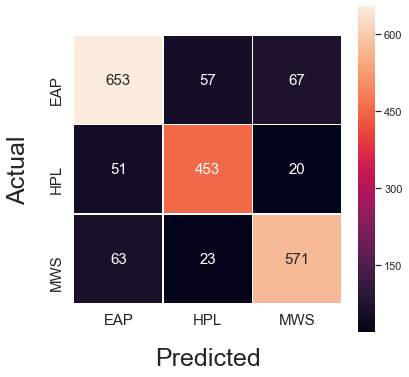

In [35]:
show_confusion_matrix(y_test, sclf_predictions)

**Note**: From here on, we can also tune hyperparameters of the stacking ensemble model to possibly get an even better log loss and accuracy ([reference](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#example-3-stacked-classification-and-gridsearch)) but since it would take significant time to run, we would skip it here

## 8.4 Neural net based models

In this section, we would build neural net classifiers on the textual data. As neural nets work better with dense input representations, we would be using **word embeddings** as features/inputs to train the neural net classifiers (as opposed to count/TF-IDF vectorizer features which are sparse). The following models would be tried:
- **LSTM**: They are a type of recurrent model that take in sequential data and produce a sequential or non-sequential output. One drawback however is that they only store past information. Bi-directional LSTMs store information both ways viz. from past to future and from future to past and have shown to perform better than uni-directional LSTMs on many tasks
- **GRU**: They are a more recent recurrent model class which have shown good performance on some tasks
- **CNN**: CNNs are adept at finding patterns in sentences irrespective of their position in the text

We would mostly try shallow models as they have shown good performance on text classification tasks unlike computer vision which thrives on deep models.

**Note**: We would not be doing any text preprocessing (e.g. punctuation removal, stopword removal, etc.) before forming the word embeddings as that seems to worsen model performance (as observed from benchmark model evaluation).

We first define some functions that would be used by all the neural net models.

In [36]:
# takes in input model and best weights filepath and returns true labels, predicted labels and predicted class probabilities
def evaluate_model(model, weights_path, X_enc, y_enc):
    """
    inputs:
       - model: keras model object
       - weights_path: filepath (hdf5) of weights to load into the model
       - X_enc: features for which prediction needs to be obtained
       - y_enc: ground truth target labels
    """    
    model.load_weights(weights_path)
    y_true = np.argmax(y_enc, axis=1)
    y_pred_proba = model.predict(X_enc)
    y_pred = np.argmax(y_pred_proba, axis=1)
    loss = metrics.log_loss(y_true, y_pred_proba)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    print('Loss: {}, accuracy: {}'.format(loss, accuracy))
    return y_true, y_pred, y_pred_proba
    
# plot training/validation loss/accuracy across epochs
def show_train_val_loss_accuracy(history):
    """
    inputs:
       - history: keras history object obtained from model fitting
    """        
    metrics = [['loss','val_loss'],['acc','val_acc']]
    titles = ['Tracking Log-loss','Tracking Accuracy']
    ylabels = ['Loss','Accuracy']
    legend_placement = ['upper right', 'upper left']
    fig = plt.figure(figsize=(15,5))
    for metric_counter, metric in enumerate(metrics):
        ax = fig.add_subplot(1, 2, metric_counter+1)
        _ = plt.plot(history.history[metric[0]])
        _ = plt.plot(history.history[metric[1]])
        _ = plt.title(titles[metric_counter], fontsize=18)
        _ = plt.ylabel(ylabels[metric_counter], fontsize=15)
        _ = plt.xlabel('Epoch', fontsize=15)
        _ = plt.legend(['Train', 'Validation'], loc=legend_placement[metric_counter])
    plt.show()    

Next we carve out features/inputs which would be fed into all neural net models- we would be using the keras Tokenizer API. We would be using GloVe pre-trained embeddings as they are more contemporary and have shown to perform well on many textual tasks. Since our vocabulary is more sophisticated (taken from novels), we would be using pre-trained word vectors based on a more elaborate corpus viz. ~42B tokens (300-dimensional) containing ~2M vocabulary from GloVe website.

**Note**: For running the below code, GloVe 42B tokens (300-dimensional) embeddings needs to be downloaded from the [GloVe website](http://nlp.stanford.edu/data/glove.42B.300d.zip), unzipped to extract the `txt` file and then put in the folder `pre-trained word embeddings`

In [37]:
# declaring and fitting keras tokenizer object on train data
# text sequences are clipped to 95 percentile threshold of word counts across sentences to avoid padding too many 0s
word_index, X_train_enc, X_test_enc = tokenize_encode_documents(X_train.text, X_test.text, 95)
vocab_size = len(word_index)+1
max_length = X_train_enc[0].shape[0] # all are same length so we can pick any

Generated sequences with similar lengths of 58


In [38]:
# Fetching pre-trained GloVe embedding weights
embedding_matrix, embedding_dim = map_word_to_embeddings('pre-trained word embeddings/glove.42B.300d.txt', 'utf8', word_index)

In [39]:
# also encoding target labels in a binary matrix format which would be suitable for neural net fitting
y_train_enc = np_utils.to_categorical(y_train)
y_test_enc = np_utils.to_categorical(y_test)

Now we would move onto model fitting. Incidentally, the loss function we would be using (`log loss`) also happens to be our evaluation metric. Hence, when we track the loss, we automatically track our evaluation metric. Hence, we would rather track `accuracy` as a metric explicitly instead.

Also as our train corpus is not large (17k sentences only), we would not train the embedding vector weights (`trainable=False`).

**Note**: The below neural net models would take some time to run (~15 minutes each) on a GPU. Please make sure you are running it on a GPU powered machine

### 8.4.1 LSTM
We fit the LSTM model on the data first. The LSTM layer would be preceded by an Embedding layer which would be initialized with the pre-trained GloVe weights (as obtained above).

We would try both the uni-directional and bi-directional LSTMs.

#### 8.4.1.1 Uni-directional LSTM

In [40]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(512, activation='relu'))
lstm_model.add(Dropout(rate=0.3))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 300)           7464000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 58, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)      

In [41]:
# We will keep verbose=0 to avoid swamping the output. We would track the train/validation metrics later in the epoch plot
batch_size = 512
epochs = 100
lstm_history = History()

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.lstm.hdf5', verbose=0, save_best_only=True)

lstm_history = lstm_model.fit(X_train_enc, y_train_enc,
                              batch_size=batch_size, epochs=epochs,
                              verbose=0, validation_split=0.1,
                             callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.


In [42]:
# Evaluate model performance on test data based on best saved weights
_ = evaluate_model(lstm_model, 'saved_models/weights.best.lstm.hdf5', X_test_enc, y_test_enc)

Loss: 0.48791537410037894, accuracy: 0.8094994892747702


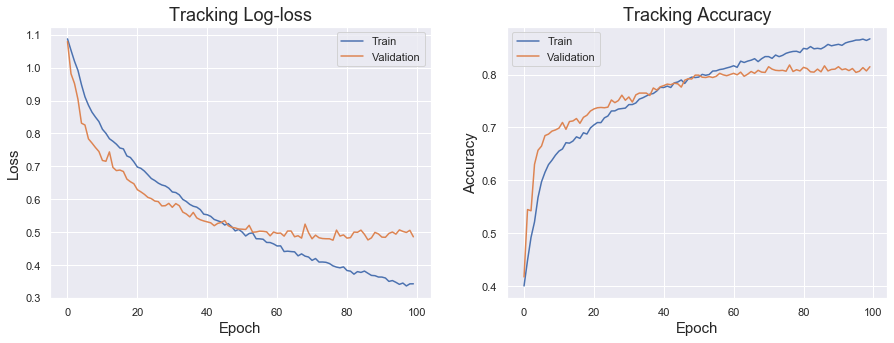

In [43]:
# plotting train/validation loss/accuracy across epochs
show_train_val_loss_accuracy((lstm_history))

We see here that the performance of the preliminary uni-directional LSTM model (log loss: ~0.48) on the test data is satisfactory but still below the benchmark model. We would try out the bi-directional LSTM now

#### 8.4.1.2 Bi-directional LSTM
Next we try out the bi-directional LSTM. All the settings are the same as uni-directional LSTM to enable an apples to apples comparison

In [44]:
lstm_bd_model = Sequential()
lstm_bd_model.add(Embedding(vocab_size,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False))
lstm_bd_model.add(SpatialDropout1D(0.3))
lstm_bd_model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
lstm_bd_model.add(Dense(512, activation='relu'))
lstm_bd_model.add(Dropout(rate=0.3))
lstm_bd_model.add(Dense(3, activation='softmax'))
lstm_bd_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_bd_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 58, 300)           7464000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 58, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 7,889,251
Trainable params: 425,251
Non-trainable params: 7,464,000
____________________________________________________________

In [45]:
# We will keep verbose=0 to avoid swamping the output. We would track the train/validation metrics later in the epoch plot
batch_size = 512
epochs = 100
lstm_bd_history = History()

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.lstm_bd.hdf5', verbose=0, save_best_only=True)

lstm_bd_history = lstm_bd_model.fit(X_train_enc, y_train_enc,
                              batch_size=batch_size, epochs=epochs,
                              verbose=0, validation_split=0.1,
                             callbacks=[checkpointer])

In [46]:
# Evaluate model performance on test data based on best saved weights
_ = evaluate_model(lstm_bd_model, 'saved_models/weights.best.lstm_bd.hdf5', X_test_enc, y_test_enc)

Loss: 0.5032602586783781, accuracy: 0.8013278855975485


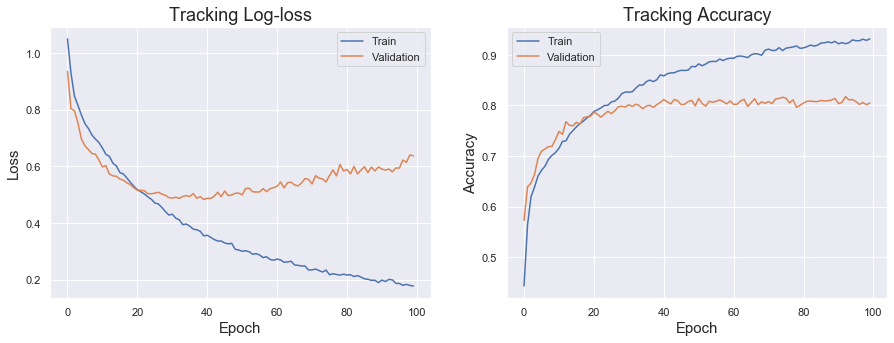

In [47]:
# plotting train/validation loss/accuracy across epochs
show_train_val_loss_accuracy((lstm_bd_history))

It seems that Bi-directional LSTM is not helping here and leading to overfitting of the model. We try the GRU next.

### 8.4.2 GRU
We fit the GRU layer on the data now. The settings remain largely same as in LSTM.

#### 8.4.2.1 Single GRU layer
We first start by a single GRU layer.

In [48]:
gru_model = Sequential()
gru_model.add(Embedding(vocab_size,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
gru_model.add(Dense(512, activation='relu'))
gru_model.add(Dropout(rate=0.3))
gru_model.add(Dense(3, activation='softmax'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 300)           7464000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 58, 300)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               120300    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1539      
Total params: 7,637,551
Trainable params: 173,551
Non-trainable params: 7,464,000
____________________________________________________________

In [49]:
# We will keep verbose=0 to avoid swamping the output. We would track the train/validation metrics later in the epoch plot
batch_size = 512
epochs = 100
gru_history = History()

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.gru.hdf5', verbose=0, save_best_only=True)

gru_history = gru_model.fit(X_train_enc, y_train_enc,
                              batch_size=batch_size, epochs=epochs,
                              verbose=0, validation_split=0.1,
                             callbacks=[checkpointer])

In [50]:
# Evaluate model performance on test data based on best saved weights
_ = evaluate_model(gru_model, 'saved_models/weights.best.gru.hdf5', X_test_enc, y_test_enc)

Loss: 0.46980584259075275, accuracy: 0.8120531154239019


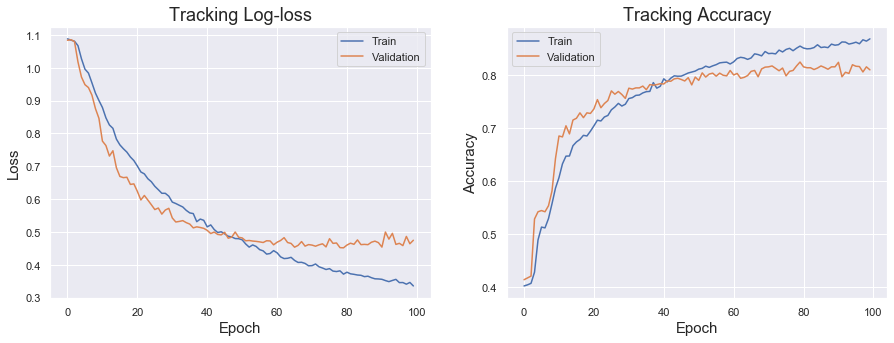

In [51]:
# plotting train/validation loss/accuracy across epochs
show_train_val_loss_accuracy((gru_history))

So the GRU model avoids overfitting (train/validation trajectories are similar), however, it gives performance at-par with the LSTM i.e. still below the benchmark model 

#### 8.4.2.2 Stacked GRU layers
We try a stacked GRU model now.

In [52]:
gru_stack_model = Sequential()
gru_stack_model.add(Embedding(vocab_size,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False))
gru_stack_model.add(SpatialDropout1D(0.3))
gru_stack_model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
gru_stack_model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
gru_stack_model.add(Dense(512, activation='relu'))
gru_stack_model.add(Dropout(rate=0.3))
gru_stack_model.add(Dense(3, activation='softmax'))
gru_stack_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_stack_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 58, 300)           7464000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 58, 300)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 58, 100)           120300    
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 1539      
Total para

In [53]:
# We will keep verbose=0 to avoid swamping the output. We would track the train/validation metrics later in the epoch plot
batch_size = 512
epochs = 100
gru_stack_history = History()

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.gru_stack.hdf5', verbose=0, save_best_only=True)

gru_stack_history = gru_stack_model.fit(X_train_enc, y_train_enc,
                              batch_size=batch_size, epochs=epochs,
                              verbose=0, validation_split=0.1,
                             callbacks=[checkpointer])

In [54]:
# Evaluate model performance on test data based on best saved weights
_ = evaluate_model(gru_stack_model, 'saved_models/weights.best.gru_stack.hdf5', X_test_enc, y_test_enc)

Loss: 0.4465292016934893, accuracy: 0.8207354443309499


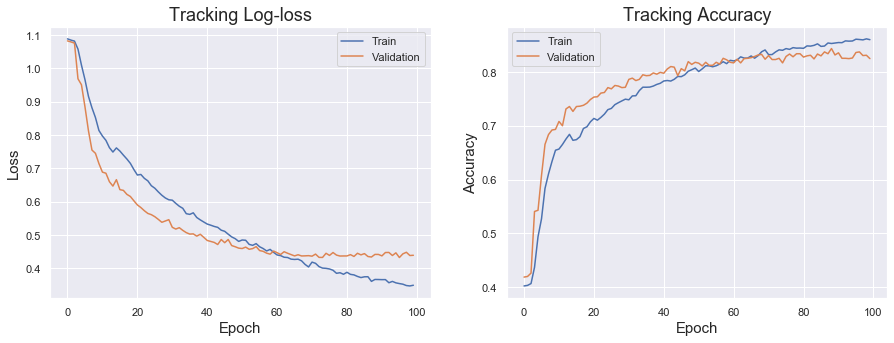

In [55]:
# plotting train/validation loss/accuracy across epochs
show_train_val_loss_accuracy((gru_stack_history))

So we see the stacked GRU model has produced better performance than other neural architectures (log loss ~ 0.45) but still could not beat the benchmark model

### 8.4.3 CNN
Finally, we would fit the CNN model which has shown to perform well for text classification problems. We would reduce the number of epochs for CNN as they are known to train faster.

In [56]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(3, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 58, 300)           7464000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 128)           115328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                23050     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 33        
Total para

In [57]:
# We will keep verbose=0 to avoid swamping the output. We would track the train/validation metrics later in the epoch plot
batch_size = 512
epochs = 20
cnn_history = History()

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.cnn.hdf5', verbose=0, save_best_only=True)

cnn_history = cnn_model.fit(X_train_enc, y_train_enc,
                              batch_size=batch_size, epochs=epochs,
                              verbose=0, validation_split=0.1,
                             callbacks=[checkpointer])

In [58]:
# Evaluate model performance on test data based on best saved weights
_ = evaluate_model(cnn_model, 'saved_models/weights.best.cnn.hdf5', X_test_enc, y_test_enc)

Loss: 0.6433829503980433, accuracy: 0.7436159346271706


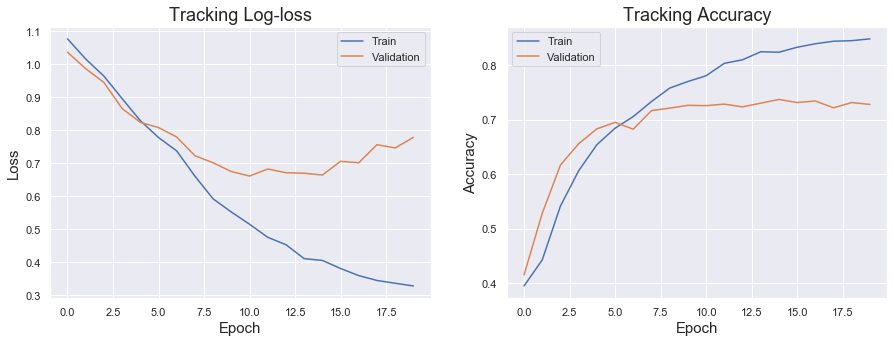

In [59]:
# plotting train/validation loss/accuracy across epochs
show_train_val_loss_accuracy((cnn_history))

We see that contrary to expectation, CNN does not perform well here.

So to conclude, neural net models perform decent but not extraordinary on our text excerpts. The ML models seem to perform better on this problem. We could try different neural net architectures or pre-process text (stemming, stopwords removal, etc.) to further fine tune the model but we would leave it for now as hyperparameter optimization on such complex models can take hours to run.

## 8.5 FastText model
Finally, we would try the [FastText model](https://fasttext.cc/) by Facebook. We first do some data pre-processing as recommended in FastText documentation viz. punctuation removal and lower casing. Then we convert and save the data in the format required by FastText algorithm i.e. complete observation in one line with labels (preceded by the literal *\__label__*) before the sentence. The file is stored as `txt` file (and later read back in) as the FastText algorithm requires external train filepaths for model fitting.

In [60]:
# data preprocessing
X_train_fastext = preprocess_text(X_train.text, rm_punc=True, rm_lowercase=True, rm_lemma=False, rm_stopwords=False)
X_test_fastext = preprocess_text(X_test.text, rm_punc=True, rm_lowercase=True, rm_lemma=False, rm_stopwords=False)

In [61]:
# saving train data in required format to a txt file
f_train = open("fasttext files/train.txt","w+", encoding="utf-8") # create/overwrite the file
for i in range(len(y_train)):
    f_train.write("__label__%d %s\n" %(y_train[i], X_train_fastext.iloc[i]))
f_train.close()

Next we make a function to evaluate the log loss and accuracy of the model on test data by changing three parameters viz. `epoch`, `lr` (learning rate) and `wordNgrams`. These parameters are also fine tuned in the [FastText tutorial](https://fasttext.cc/docs/en/supervised-tutorial.html) on the official website.

In [62]:
# defaulting epoch, lr and wordNgrams to official default values in fasttext
def evaluate_fasttext_model(train_filepath, X_test, y_test, epoch=5, lr=0.1, wordNgram=1):
    """
    inputs:
       - train_filepath: filepath of train txt file
       - X_test: python test features object
       - y_test: python test target object
       - epoch: epoch setting for fasttext.train_supervised function
       - lr: learning rate setting for fasttext.train_supervised function
       - wordNgram: wordNgrams setting for fasttext.train_supervised function
    """     
    model = fasttext.train_supervised(input=train_filepath, epoch=epoch, lr=lr, wordNgrams=wordNgram)
    probs=[]
    labels=[]
    for i in range(len(X_test)): 
        prediction = model.predict(X_test.iloc[i], k=3)
        # Rerranging probabilities in order of label_0, label_1 and label_2 (instead of descending probability order)
        probs.append([prediction[1][prediction[0].index(i)] for i in ['__label__0', '__label__1', '__label__2']])
        labels.append(int(prediction[0][0][-1]))
    return metrics.log_loss(y_test, probs), metrics.accuracy_score(y_test, labels)

### 8.5.1 Standard FastText model
We start by building a standard model with no tuning.

In [63]:
ft_loss, ft_acc = evaluate_fasttext_model("fasttext files/train.txt", X_test_fastext, y_test)
print('Loss: {}, Accuracy: {}'.format(ft_loss, ft_acc))

Loss: 0.5033644281324849, Accuracy: 0.8171603677221655


### 8.5.2 Hyperparameter Tuning
A hyperparameter [autotune functionality](https://fasttext.cc/docs/en/autotune.html) was recently introduced in FastText but since that only optimizes `f1-score`, we would build our own hyperparameter tuning module (for tuning our evaluation metric viz. `multi log-loss`). It would be a brute force grid search that searches for all possible combinations of our hyperparameters and finds the best one. Since FastText model is built to be fast (even while on CPU), we can afford the luxury of running many model combinations here.

In [64]:
start_time = time()

epochs = [3, 5, 10, 20, 50]
lrs = [0.05, 0.1, 0.3, 0.7, 1]
wordNgrams = [1, 2, 3]

ft_result = {}
ft_result['scenarios'] = []
ft_result['loss'] = []
ft_result['accuracy'] = []

for epoch in epochs:
    for lr in lrs:
        for wordNgram in wordNgrams:
            scenario = 'epoch_' + str(epoch) + '_lr_' + str(lr) + '_wordNgram_' + str(wordNgram)
            ft_result['scenarios'].append(scenario)
            loss, acc = evaluate_fasttext_model("fasttext files/train.txt", X_test_fastext, y_test,
                                               epoch=epoch, lr=lr, wordNgram=wordNgram)
            ft_result['loss'].append(loss)
            ft_result['accuracy'].append(acc)

end_time = time()

print("Complete in {} minutes".format(round((end_time-start_time)/60,1)))

Complete in 6.5 minutes


In [65]:
# putting results in a dataframe object and finding the scenario with lowest log loss
ft_result_df = pd.DataFrame(ft_result)
ft_result_df.loc[ft_result_df.loss.idxmin()]

scenarios    epoch_20_lr_0.05_wordNgram_2
loss                             0.484616
accuracy                         0.836568
Name: 46, dtype: object

Hence, we see that the lowest log loss is ~0.48 (with accuracy of ~0.84) and is obtained with the following parameter values:
- `epoch` = 10
- `lr` = 0.1
- `wordNgrams` = 2

However, this best FastText log loss is still below the benchmark model.

# 9. Result comparison and final model selection
To conclude, we observed that the conventional ML models had the best performance in general with the stacking ML ensemble on multiple features showing the best (minimum) log loss. To summarize, following are the **results in descending order of evaluation metric (log loss) performance** i.e. best to worst (benchmark model has been shown in bold):

|                         Model Name (best to worst)            | Log Loss   | Accuracy |
|:--------------------------------------------------------------|:----------:|:--------:|
|Stacked ML ensemble (same learner different features)          | 0.37       |   0.86   |
|Stacked ML ensemble (multiple learners same features)          | 0.39       |   0.84   |
|SVC TF-IDF model (tuned)                                       | 0.42       |   0.84   |
|***Benchmark model (Logistic regression on count features)***  |**0.44**    | **0.83** |
|Stacked GRU                                                    | 0.45       |   0.82   |
|FastText model (tuned)                                         | 0.48       |   0.84   |

Based on the results, we would choose the **Stacked ML ensemble (same learner different features)** as our final model. This model has the best log loss of **0.37** and also best accuracy of **0.86**.



# 10. Sensitivity analysis of final model
We would now conduct a sensitivity analysis of our final chosen model (i.e. stacking ensemble on same learner different features) in order to ascertain its **robustness under different conditions**. For this, we would randomly remove a fraction of words from each sentence in the test data and check its effect on model performance. If the model is robust, it's performance should not be greatly affected by slight changes in the test data.

We start by defining a function `examine_word_removal_sensitivity` which returns the updated model performance on removing a fraction of words from each sentence in test set.

**Note**: We used the same model object name viz. `sclf` for both the stacking ensemble models but the final stacking ensemble chosen was fitted later. Hence, the `sclf` model object still in fact stores the final chosen stacking ensemble with best performance!

In [191]:
def remove_words(sent, fraction_rm):
    sent = sent.split()
    sent_len = len(sent)
    total_rm = math.ceil(sent_len*fraction_rm) # total words to remove
    indexes_to_rm = np.random.choice(sent_len, total_rm, replace=False) # randomly selected word indexes to remove in sentence
    final_sent = ' '.join([word for word in sent if sent.index(word) not in indexes_to_rm])
    return final_sent

def examine_word_removal_sensitivity(X_test, y_test, fraction_rm):
    X_test_modified = X_test.copy()
    X_test_modified.text = X_test_modified.text.apply(remove_words, fraction_rm=fraction_rm)
    
    # updating the meta features as sentences have been shortened    
    X_test_modified['char_count'] =              X_test_modified['text'].apply(len)
    X_test_modified['word_count'] =              X_test_modified['text'].apply(lambda x: len(x.split()))
    X_test_modified['word_density'] =            X_test_modified['char_count'] / (X_test_modified['word_count'] + 1)
    X_test_modified['punctuation_count'] =       X_test_modified['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    X_test_modified['title_word_count'] =        X_test_modified['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    X_test_modified['upper_case_word_count'] =   X_test_modified['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

    X_test_modified['noun_count'] =  X_test_modified['text'].apply(lambda x: check_pos_tag(x, 'noun'))
    X_test_modified['verb_count'] =  X_test_modified['text'].apply(lambda x: check_pos_tag(x, 'verb'))
    X_test_modified['adj_count'] =   X_test_modified['text'].apply(lambda x: check_pos_tag(x, 'adj'))
    X_test_modified['adv_count'] =   X_test_modified['text'].apply(lambda x: check_pos_tag(x, 'adv'))
    X_test_modified['pron_count'] =  X_test_modified['text'].apply(lambda x: check_pos_tag(x, 'pron'))

    # updating fractional metrics for each sentence as sentences have been shortened
    X_test_modified['frac_punctuation_count'] =      X_test_modified['punctuation_count']/X_test_modified['char_count']
    X_test_modified['frac_title_word_count'] =       X_test_modified['title_word_count']/X_test_modified['word_count']
    X_test_modified['frac_upper_case_word_count'] =  X_test_modified['upper_case_word_count']/X_test_modified['word_count']

    X_test_modified['frac_noun_count'] =             X_test_modified['noun_count']/X_test_modified['word_count']
    X_test_modified['frac_verb_count'] =             X_test_modified['verb_count']/X_test_modified['word_count']
    X_test_modified['frac_adj_count'] =              X_test_modified['adj_count']/X_test_modified['word_count']
    X_test_modified['frac_adv_count'] =              X_test_modified['adv_count']/X_test_modified['word_count']
    X_test_modified['frac_pron_count'] =             X_test_modified['pron_count']/X_test_modified['word_count']
    
    # preparing new test features for inputing into stacking ensemble
    X_test_modified_ML_meta = X_test_modified.drop('text', axis = 1)
    _, X_test_modified_ML_count = count_tfidf_vectorizer(X_train.text, X_test_modified.text, mode='count')
    _, X_test_modified_ML_tfidf = count_tfidf_vectorizer(X_train.text, X_test_modified.text, mode='tfidf')

    _, X_test_modified_ML_count_char = count_tfidf_vectorizer(X_train.text, X_test_modified.text,
                                                                analyzer='char', ngram_range=(1,5), mode='count')
    _, X_test_modified_ML_tfidf_char = count_tfidf_vectorizer(X_train.text, X_test_modified.text,
                                                                analyzer='char', ngram_range=(1,5), mode='tfidf')
    
    X_test_modified_ML_combined_count_tfidf = sparse.hstack([X_test_modified_ML_count, X_test_modified_ML_tfidf,
                                  X_test_modified_ML_count_char, X_test_modified_ML_tfidf_char, X_test_modified_ML_meta])
    
    sclf_modified_predictions = sclf.predict(X_test_modified_ML_combined_count_tfidf.toarray())
    sclf_modified_predictions_proba = sclf.predict_proba(X_test_modified_ML_combined_count_tfidf.toarray())
    
    log_loss_modified = metrics.log_loss(y_test, sclf_modified_predictions_proba)
    acc_modified = metrics.accuracy_score(y_test, sclf_modified_predictions)
    return log_loss_modified, acc_modified


Now, we check the final model performance on removing different word count fractions from each sentence (from 10% to 60%). We then store the sensitivity results in a dataframe and plot the results.

In [192]:
start_time = time()

sensitivity={}
sensitivity['fraction_rm'] = []
sensitivity['loss'] = []
sensitivity['accuracy'] = []

for fraction_rm in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    sensitivity['fraction_rm'].append(fraction_rm)
    ll, acc = examine_word_removal_sensitivity(X_test, y_test, fraction_rm)
    sensitivity['loss'].append(ll)
    sensitivity['accuracy'].append(acc)
    
end_time = time()

print("Complete in {} minutes".format(round((end_time-start_time)/60,1)))

Complete in 9.0 minutes


In [219]:
# storing sensitivity results in a dataframe and displaying results
sensitivity_df = pd.DataFrame(sensitivity)
sensitivity_df

,fraction_rm,loss,accuracy
0,0.0,0.369810,0.856486
1,0.1,0.395152,0.843718
2,0.2,0.427593,0.821757
3,0.3,0.458729,0.808478
4,0.4,0.517369,0.784985
5,0.5,0.557867,0.766599
6,0.6,0.646589,0.720633


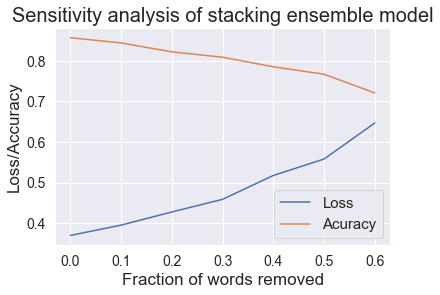

In [221]:
# plotting results
_ = plt.plot(sensitivity_df.loss)
_ = plt.plot(sensitivity_df.accuracy)
_ = plt.title('Sensitivity analysis of stacking ensemble model', fontsize=20)
_ = plt.xticks(np.arange(7), labels=sensitivity_df.fraction_rm, fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.ylabel('Loss/Accuracy', fontsize=17)
_ = plt.xlabel('Fraction of words removed', fontsize=17)
_ = plt.legend(['Loss', 'Acuracy'], loc='best', fontsize=15)
plt.show()

We observe the following:
* Model log loss still beats the benchmark model (log loss ~ 0.43) even on removing 20% of words in each sentence
* Model performance only starts to significantly degrade on removing 40% of words (log loss ~ 0.52) or more

Hence, we conclude that the **stacking ensemble model chosen is robust** under small changes in the input data.

# 11. Learnings
To summarize, we can conclude the following:
* Data pre-processing techniques like punctuation removal, stopwords removal, lemmatization, etc. might not always increase performance and could rather lead to worse performance depending on data
* Model ensembles have great potential in bumping up accuracy and log loss but can become black boxes pretty soon
* Neural net don't always perform better than simpler ML models. Neural net may need larger train corpus and sophisticated hyperparameter tuning than ML models to shine
* Off-the-shelf models like FastText can provide quicker and faster insights but might become limiting after some time